# GPS数据时间信息渲染

In [16]:
#通过车辆的id来筛选出车辆的GPS点，然后根据时间序列进行排序，
# 将这个序列通过图像的边缘进行截断，每部分都是一条轨迹，然后将时间序列渲染用颜色渲染出来，颜色的话使用rgb通道来表示，
# sin和cos的值用来表示时间。这两个函数的一个完整的周期刚好可以表示

# 1. 读取数据
# 2. 通过车辆id来筛选出车辆的GPS点,分成不同的数组，然后根据时间序列进行排序
# 3. 将这个序列通过图像的边缘进行截断，每部分都是一条轨迹，然后将时间序列渲染用颜色渲染出来，颜色的话使用rgb通道来表示，
# sin和cos的值用来表示时间。这两个函数的一个完整的周期刚好可以表示
# 4. 保存图片


In [1]:
import pandas as pd
import numpy as np
import cv2
import pickle
import sys
from PIL import Image
from tqdm import tqdm
sys.path.append('..')

In [18]:
def _sparse_to_dense(patchedGPS, length=1024):
    """GPS点直接渲染"""
    gps = np.zeros((length, length, 1), np.uint8)
    ratio = length / 1024.
    patchedGPS = patchedGPS[(0 <= patchedGPS['lat']) & (patchedGPS['lat'] < 1024) &
                            (0 <= patchedGPS['lon']) & (patchedGPS['lon'] < 1024)]
    y = np.array(patchedGPS['lon'] * ratio, np.int_)
    x = np.array(patchedGPS['lat'] * ratio, np.int_)

    gps[x, y] = 255

    gps = cv2.dilate(gps, np.ones((3, 3))) # 膨胀
    gps = gps[..., None] # 增加一个维度
    return gps


In [19]:
def GPS_sort_by_time(df):
    """按车牌号筛选，按时间信息排序"""

    # Get the unique carid values
    unique_carids = df['carID'].unique()

    # Initialize an empty DataFrame to store the sorted results
    sorted_dataframes = []

    # Loop through each unique carid
    for carid in tqdm(unique_carids):
        # Filter the DataFrame by the current carid
        filtered_df = df[df['carID'] == carid]

        # Sort the filtered DataFrame by a specific column (e.g., 'brand')
        sorted_df = filtered_df.sort_values(by='systime')

        # Append the sorted DataFrame to the list
        sorted_dataframes.append(sorted_df)

    print(sorted_dataframes[0].shape)

    return sorted_dataframes


In [20]:
def split_by_time(sorted_dfs):
    """按照30minates的时间间隔对排序后的数据进行切分"""
    # Initialize a list to hold the split DataFrames
    split_dataframes = []
    # Initialize variables to keep track of the time interval
    time_interval = pd.Timedelta(minutes=30)

    # Iterate through the sorted DataFrame
    iterer = tqdm(sorted_dfs)
    for sorted_df in iterer:
        # current_df = pd.DataFrame()
        current_df = []
        previous_time = None
        for index, row in sorted_df.iterrows():
            time = row['systime']
            if previous_time is None:
                previous_time = time
            if time - previous_time > time_interval:
                split_dataframes.append(current_df)
                current_df = []
            current_df.append(tuple(row))
            previous_time = time
        # Append the last DataFrame
        split_dataframes.append(current_df)
        iterer.set_description_str(f"Split DataFrame {len(split_dataframes)}")

    # Display the split DataFrames
    # for i, split_df in enumerate(split_dataframes):
    #     print(f"Split DataFrame {i}:\n{split_df}")
    return split_dataframes


In [21]:
def render_by_time(dfs):
    """按照时间来渲染数据"""
    gps_image = np.zeros((1024, 1024, 4))
    for df in tqdm(dfs):
        #过滤一下数据，去除异常值
        # dflong, dflat = zip(*[
        #     (t[3], t[4]) for t in df if 0 <= t[3] < 1024 and 0 <= t[4] < 1024] )

        dflong = []
        dflat = []
        dspeed = []
        for t in df:
            if 0 <= t[3] < 1024 and 0 <= t[4] < 1024:
                # print(t[3], t[4])
                dflong.append(t[3])
                dflat.append(t[4])
                dspeed.append(t[5])

        n = len(dflong)
        # n = eachID_num[carid]
        # t = np.arange(n) / n * 2 * np.pi
        t = np.arange(n) / n * np.pi

        t1, t2 = (np.sin(t) + 1) / 2, (np.cos(t) + 1) / 2
        # lats = np.array(lat_carid + 0.5, np.int_)
        # lons = np.array(lon_carid + 0.5, np.int_)
        v = np.stack([t1, t2, dspeed, np.ones_like(t1)], axis=-1)
        gps_image[dflat, dflong] += v
        # gps_image = cv2.dilate(gps_image, np.ones((3, 3))) # 膨胀
    return gps_image


In [22]:
with open("../Datasets/dataset_nofootpath/GPS/bus/0_1_gps.pkl", 'rb') as f:
    patchedGPS = pickle.load(f)
print(patchedGPS.shape)
patchedGPS.systime = pd.to_datetime(patchedGPS.systime)

sorted_dfs = GPS_sort_by_time(patchedGPS) #按照车牌号筛选，按时间信息排序
split_dfs = split_by_time(sorted_dfs) #按照30分钟的时间间隔拆分轨迹


(355447, 9)


100%|██████████| 3235/3235 [01:04<00:00, 50.04it/s]


(155, 9)


Split DataFrame 23710: 100%|██████████| 3235/3235 [00:26<00:00, 122.83it/s]


In [3]:
with open("../Datasets/dataset_1024/GPS/bus/0_1_gps.pkl", 'rb') as f:
    patchedGPS = pickle.load(f)
patchedGPS

,systime,device,carID,lon,lat,speed,direction,dspeed,mileage
3857,2020-10-09T00:04:52.000Z,BS08321D,BS08321D,774,220,22.0,0.0,0.0,121405.281250
225624,2020-10-09T06:33:51.000Z,SZBT9617,SZBT9617,117,378,14.0,0.0,0.0,44825.550781
233961,2020-10-09T06:41:07.000Z,BS01410D,BS01410D,841,174,0.0,0.0,0.0,113605.429688
234068,2020-10-09T06:41:11.000Z,BS38462D,BS38462D,795,203,0.0,0.0,0.0,165309.656250
236201,2020-10-09T06:43:00.000Z,BS01410D,BS01410D,13,461,27.0,0.0,0.0,113605.429688
...,...,...,...,...,...,...,...,...,...
278726027,2019-10-09T22:52:58.000Z,1646467,BS05116D,593,266,0.0,252.0,0.0,127006.000000
278764923,2019-10-09T23:39:15.000Z,BS07377D,BS07377D,801,196,16.0,0.0,0.0,163492.531250
278765758,2019-10-09T23:39:55.000Z,BS07377D,BS07377D,597,259,0.0,0.0,0.0,163492.531250
278782280,2019-10-09T23:55:31.000Z,BS06069D,BS06069D,969,152,0.0,0.0,0.0,141637.765625


In [23]:
gps_image_array = render_by_time(split_dfs)


100%|██████████| 23710/23710 [00:01<00:00, 17031.47it/s]


[ 1.        1.       88.800003  1.      ]


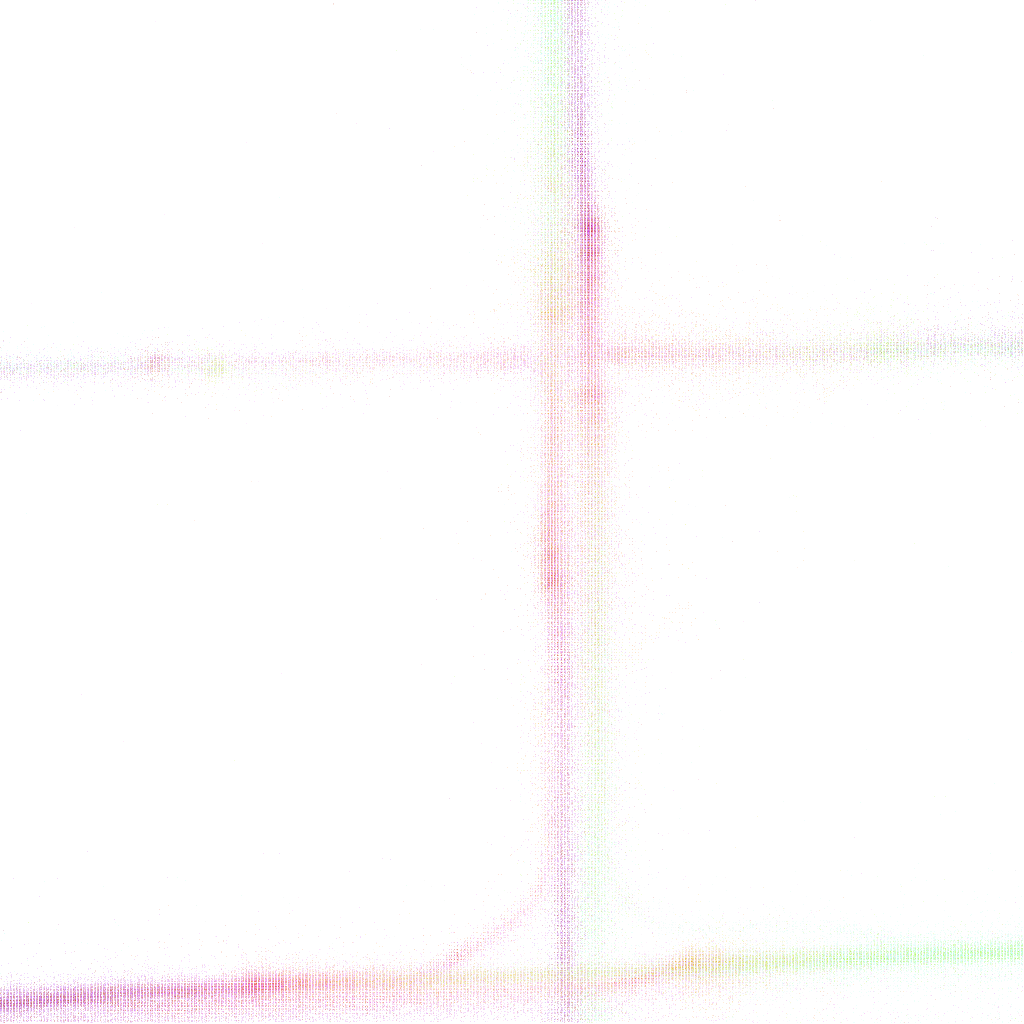

In [24]:
freq = gps_image_array[..., 3]
#给二维alpha通道添加一个纬度并且复制一份，变成三维的二通道
freq = np.repeat(freq[..., None], 3, axis=-1)
gps_image_array2 = gps_image_array.copy()
#对每个点的R、G、B通道进行归一化，这个点的像素累加和除以这个点经过车辆的总数
gps_image_array2[..., :3] /= freq.clip(1)

#持久化存储…………
with open('output.pkl', 'wb') as f:
    pickle.dump(gps_image_array2, f)

#对alpha通道取对数，加一防止出现负数，这里后续可以继续进行扩展
gps_image_array2[..., 3] = np.log(gps_image_array2[..., 3] + 1)
#对alpha通道进行归一化
gps_image_array2[..., 3] /= gps_image_array2[..., 3].max()
print(gps_image_array2.max((0, 1))) #不懂
#将RGBA四个通道映射到255的范围内
gps_image = Image.fromarray((gps_image_array2 * 255 + 0.5).astype(np.uint8))
gps_image.show()


In [30]:
#渲染完加上高斯模糊

kernel_size = (3, 3)  # Adjust the kernel size as needed
sigma = 0  # Standard deviation; 0 means automatically calculated based on kernel size

blurred_image = cv2.GaussianBlur((gps_image_array2 * 255 + 0.5).astype(np.uint8), kernel_size, sigma)

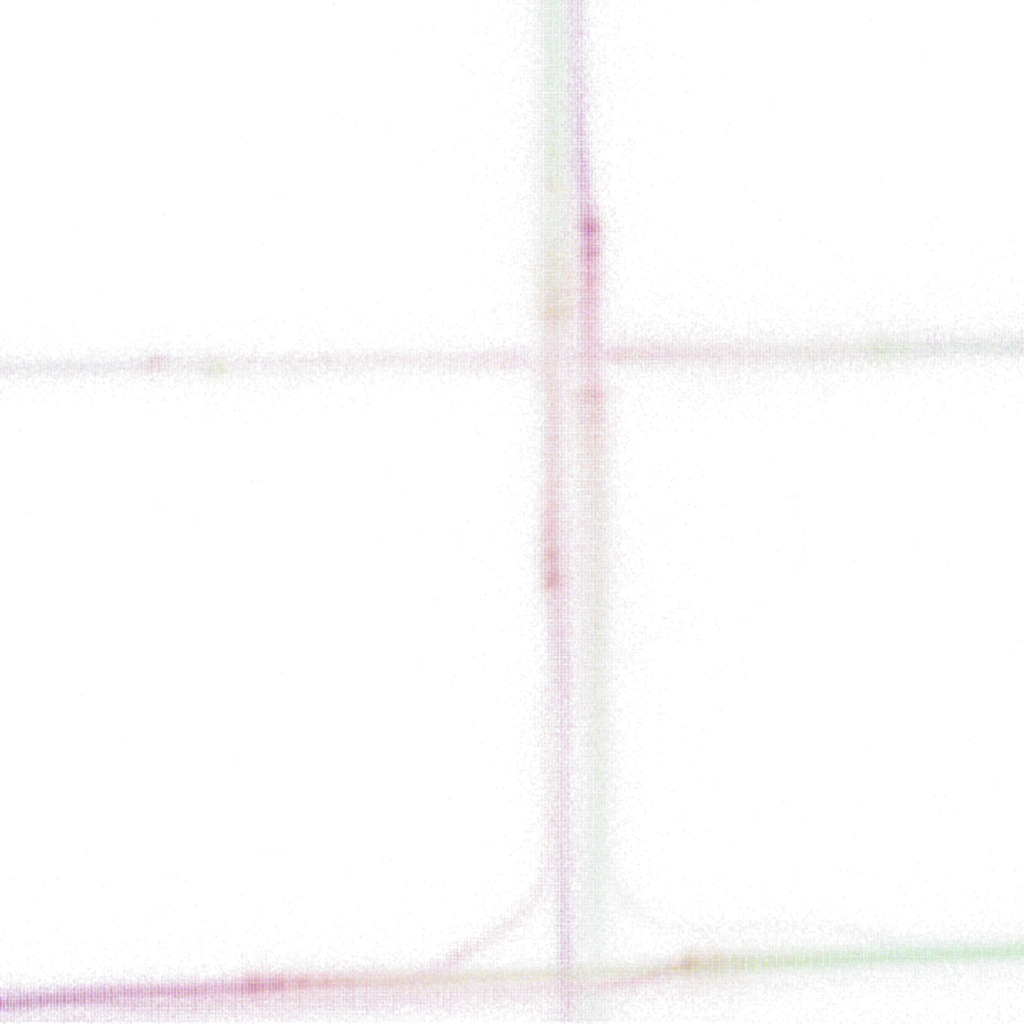

In [31]:
gps_image = Image.fromarray(blurred_image)
gps_image.show()


---